# Importing and Setting up the Custom Kernel

In [ ]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!python setup.py build_ext --inplace

running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:415: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:425: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.2
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'fused_mean_var_extension' extension
creating /content/build
creating /content/build/temp.linux-x86_64-cpython-310
Emitting ninja build file /content/build/temp.linux-x86_64-cpython-310/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/2] /usr/local/cuda/bin/nvcc --g

In [ ]:
import fused_mean_var_extension

ModuleNotFoundError: No module named 'fused_mean_var_extension'

#Custom Kernel Batch Normalization Implementation

In [ ]:
from fused_mean_var_extension import fused_mean_var

class BatchNorm1dFunctionK(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, gamma, beta, eps):
        is_3d_input = input.dim() == 3

        # Allocate memory for the output mean and variance
        features = input.size(1)
        # Initialize output tensors with the new shape
        output_mean = torch.empty((1, features, 1), device=input.device, dtype=input.dtype)
        output_var = torch.empty((1, features, 1), device=input.device, dtype=input.dtype)

        fused_mean_var(input, output_mean.view(-1), output_var.view(-1))


        # Reshape the output tensors

        # Reshape gamma and beta for broadcasting if input is 3D
        if is_3d_input:
            gamma = gamma.view(1, -1, 1)
            beta = beta.view(1, -1, 1)

        output = gamma * ((input - output_mean) / torch.sqrt(output_var + eps))+ beta

        # Save tensors for backward pass
        ctx.save_for_backward(input, gamma, beta, output_mean, output_var)
        ctx.eps = eps

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, gamma, beta, mean, var = ctx.saved_tensors
        eps = ctx.eps
        input_normalized = (input - mean) / torch.sqrt(var + eps)
        grad_input = grad_gamma = grad_beta = None

        if ctx.needs_input_grad[0]:
            if input.dim()==3:
              N = input.numel() / input.size(1)
              grad_input = (1. / N) * gamma * (var + eps).sqrt().reciprocal() * (N * grad_output - grad_output.sum(dim=[0, 2], keepdim=True) - (input - mean) * (var + eps).reciprocal() * (grad_output * (input - mean)).sum(dim=[0, 2], keepdim=True))
            else:
              grad_input = (1. / input.size(0)) * gamma * (var + eps).sqrt() * (input.size(0) * grad_output - grad_output.sum(dim=0) - input_normalized * (grad_output * input_normalized).sum(dim=0))

        if ctx.needs_input_grad[1]:
            if input.dim() == 3:
              grad_gamma = (grad_output * input_normalized).sum(dim=(0,2)).squeeze(-1)
            else:
              grad_gamma = (grad_output * input_normalized).sum(dim=0)

        if ctx.needs_input_grad[2]:
            if input.dim() == 3:
              grad_beta = grad_output.sum(dim=(0, 2)).squeeze(-1)
            else:
              grad_beta = grad_output.sum(dim=0)

        return grad_input, grad_gamma, grad_beta, None


class BatchNorm1dNewK(torch.nn.Module):
    def __init__(self, out_channels, eps=1e-5):
        super(BatchNorm1dNewK, self).__init__()
        self.gamma = nn.Parameter(torch.ones(out_channels))
        self.beta = nn.Parameter(torch.zeros(out_channels))
        self.eps = eps


    def forward(self, input):
        return BatchNorm1dFunctionK.apply(input, self.gamma, self.beta, self.eps)

ModuleNotFoundError: No module named 'fused_mean_var_extension'

#Custom Batch Normalization with Recomputation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchNorm1dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, gamma, beta, eps):
        if input.dim() == 3:
            mean = input.mean(dim=[0, 2], keepdim=True)
            var = input.var(dim=[0, 2], unbiased=False, keepdim=True)
            gamma = gamma.view(1, -1, 1)
            beta = beta.view(1, -1, 1)
        else:
            mean = input.mean(dim=0, keepdim=True)
            var = input.var(dim=0, unbiased=False, keepdim=True)


        ctx.save_for_backward(input, gamma, beta, mean, var)
        ctx.eps = eps
        return gamma * ((input - mean) / torch.sqrt(var +eps)) + beta

    @staticmethod
    def backward(ctx, grad_output):
        input, gamma, beta, mean, var = ctx.saved_tensors
        eps = ctx.eps
        input_normalized = (input - mean) / torch.sqrt(var + eps)
        grad_input = grad_gamma = grad_beta = None

        if ctx.needs_input_grad[0]:
            if input.dim()==3:
              N = input.numel() / input.size(1)
              grad_input = (1. / N) * gamma * (var + eps).sqrt().reciprocal() * (N * grad_output - grad_output.sum(dim=[0, 2], keepdim=True) - (input - mean) * (var + eps).reciprocal() * (grad_output * (input - mean)).sum(dim=[0, 2], keepdim=True))
            else:
              grad_input = (1. / input.size(0)) * gamma * (var + eps).sqrt() * (input.size(0) * grad_output - grad_output.sum(dim=0) - input_normalized * (grad_output * input_normalized).sum(dim=0))

        if ctx.needs_input_grad[1]:
            if input.dim() == 3:
              grad_gamma = (grad_output * input_normalized).sum(dim=(0,2)).squeeze(-1)
            else:
              grad_gamma = (grad_output * input_normalized).sum(dim=0)

        if ctx.needs_input_grad[2]:
            if input.dim() == 3:
              grad_beta = grad_output.sum(dim=(0, 2)).squeeze(-1)
            else:
              grad_beta = grad_output.sum(dim=0)

        return grad_input, grad_gamma, grad_beta, None

class BatchNorm1dNew(torch.nn.Module):
    def __init__(self, out_channels, eps=1e-5):
        super(BatchNorm1dNew, self).__init__()
        self.gamma = nn.Parameter(torch.ones(out_channels))
        self.beta = nn.Parameter(torch.zeros(out_channels))
        self.eps = eps


    def forward(self, input):
        return BatchNorm1dFunction.apply(input, self.gamma, self.beta, self.eps)



#Custom Batch Normalization without Recomputation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchNorm1dFunctionO(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, gamma, beta, eps):
        if input.dim() == 3:
            mean = input.mean(dim=[0, 2], keepdim=True)
            var = input.var(dim=[0, 2], unbiased=False, keepdim=True)
            gamma = gamma.view(1, -1, 1)
            beta = beta.view(1, -1, 1)
        else:
            mean = input.mean(dim=0, keepdim=True)
            var = input.var(dim=0, unbiased=False, keepdim=True)

        input_normalized = (input - mean) / torch.sqrt(var +eps)
        ctx.save_for_backward(input, gamma, beta, input_normalized, mean, var)
        ctx.eps = eps
        return gamma * input_normalized + beta

    @staticmethod
    def backward(ctx, grad_output):
        input, gamma, beta,input_normalized, mean, var = ctx.saved_tensors
        eps = ctx.eps
        grad_input = grad_gamma = grad_beta = None

        if ctx.needs_input_grad[0]:
            if input.dim()==3:
              N = input.numel() / input.size(1)
              grad_input = (1. / N) * gamma * (var + eps).sqrt().reciprocal() * (N * grad_output - grad_output.sum(dim=[0, 2], keepdim=True) - (input - mean) * (var + eps).reciprocal() * (grad_output * (input - mean)).sum(dim=[0, 2], keepdim=True))
            else:
              grad_input = (1. / input.size(0)) * gamma * (var + eps).sqrt() * (input.size(0) * grad_output - grad_output.sum(dim=0) - input_normalized * (grad_output * input_normalized).sum(dim=0))

        if ctx.needs_input_grad[1]:
            if input.dim() == 3:
              grad_gamma = (grad_output * input_normalized).sum(dim=(0,2)).squeeze(-1)
            else:
              grad_gamma = (grad_output * input_normalized).sum(dim=0)

        if ctx.needs_input_grad[2]:
            if input.dim() == 3:
              grad_beta = grad_output.sum(dim=(0, 2)).squeeze(-1)
            else:
              grad_beta = grad_output.sum(dim=0)

        return grad_input, grad_gamma, grad_beta, None

class BatchNorm1dNewO(torch.nn.Module):
    def __init__(self, out_channels, eps=1e-5):
        super(BatchNorm1dNewO, self).__init__()
        self.gamma = nn.Parameter(torch.ones(out_channels))
        self.beta = nn.Parameter(torch.zeros(out_channels))
        self.eps = eps


    def forward(self, input):
        return BatchNorm1dFunctionO.apply(input, self.gamma, self.beta, self.eps)



#Simple Gradient Testing

In [ ]:
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Create a random tensor with shape [batch_size, num_channels, length]
input_tensor = torch.randn(10, 64, 1000, requires_grad=True)

# Define the BatchNorm layers
bn_pytorch = nn.BatchNorm1d(64)
bn_custom = BatchNorm1dNew(64)

# Move tensors and models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
bn_pytorch = bn_pytorch.to(device)
bn_custom = bn_custom.to(device)

bn_pytorch.train()

# Forward pass
output_pytorch = bn_pytorch(input_tensor.clone())
output_custom = bn_custom(input_tensor.clone())

# Check outputs
close = torch.allclose(output_pytorch, output_custom, rtol=1e-5, atol=1e-8)
print(f"Outputs are close: {close}")


# Function to compare gradients
def compare_gradients(grad1, grad2, rtol=1e-5, atol=1e-8):
    if grad1 is None and grad2 is None:
        return True  # Both gradients are None, considered equivalent
    elif grad1 is not None and grad2 is not None:
        return torch.allclose(grad1, grad2, rtol=rtol, atol=atol)
    else:
        return False  # One is None and the other is not, considered different



# Compare gradients of gamma and beta
gamma_grad_close = compare_gradients(bn_pytorch.weight.grad, bn_custom.gamma.grad)
beta_grad_close = compare_gradients(bn_pytorch.bias.grad, bn_custom.beta.grad)
print(f"Gamma gradients are close: {gamma_grad_close}")
print(f"Beta gradients are close: {beta_grad_close}")



Outputs are close: True
Gamma gradients are close: True
Beta gradients are close: True


#LeNet Definitions and Data Import

In [ ]:
import torch
import torch.nn as nn

class LeNetWithBatchNorm(nn.Module):
    def __init__(self):
        super(LeNetWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        #self.bn1 = nn.BatchNorm2d(6) # Batch normalization for 6 channels
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        #self.bn2 = nn.BatchNorm2d(16) # Batch normalization for 16 channels
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Create a LeNet model with batch normalization
le1 = LeNetWithBatchNorm()

In [ ]:
class LeNetWithBatchNormUpdated(nn.Module):
    def __init__(self):
        super(LeNetWithBatchNormUpdated, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        #self.bn1 = CustomBatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        #self.bn2 = CustomBatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = BatchNorm1dNewO(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = BatchNorm1dNewO(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

le2 = LeNetWithBatchNormUpdated()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
import time
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# Step 3: Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9838442.00it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1748948.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14043901.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5801013.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#LeNet Model Training

In [ ]:
import time
def train_model(model, train_loader, epochs, optimizer, loss_function):
    # Ensure the model is in train mode
    model.train()

    # Move the model to GPU
    model = model.to('cuda')
    for epoch in range(epochs):
        epoch_start_time = time.time()
        torch.cuda.reset_peak_memory_stats()  # Reset peak memory statistics at the start of each epoch

        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_end_time = time.time()

        # Calculate and print the metrics
        epoch_memory_usage = torch.cuda.max_memory_allocated()  # Get peak memory usage for the epoch
        epoch_compute_time = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, "
              f"Memory Usage: {epoch_memory_usage} bytes, Compute Time: {epoch_compute_time} seconds")

In [ ]:
import time
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, epochs, optimizer, loss_function):
    # Lists to store metrics
    losses = []
    memory_usages = []
    compute_times = []

    # Ensure the model is in train mode
    model.train()

    # Move the model to GPU
    model = model.to('cuda')
    for epoch in range(epochs):
        epoch_start_time = time.time()
        torch.cuda.reset_peak_memory_stats()  # Reset peak memory statistics at the start of each epoch

        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_end_time = time.time()

        # Store metrics
        losses.append(total_loss / len(train_loader))
        memory_usages.append(torch.cuda.max_memory_allocated())
        compute_times.append(epoch_end_time - epoch_start_time)

        # Print metrics for each epoch
        print(f"Epoch {epoch+1}, Loss: {losses[-1]}, "
              f"Memory Usage: {memory_usages[-1]} bytes, Compute Time: {compute_times[-1]} seconds")

    # After training, plot the metrics
    plot_training_metrics(losses, memory_usages, compute_times)

def plot_training_metrics(losses, memory_usages, compute_times):
    epochs = range(1, len(losses) + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Plotting the loss per epoch
    axs[0].plot(epochs, losses, label='Loss per Epoch', color='blue', marker='o')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)

    # Plotting the memory usage per epoch
    axs[1].plot(epochs, memory_usages, label='Memory Usage per Epoch', color='red', marker='o')
    axs[1].set_title('Memory Usage per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Memory (bytes)')
    axs[1].grid(True)

    # Plotting the compute time per epoch
    axs[2].plot(epochs, compute_times, label='Compute Time per Epoch', color='green', marker='o')
    axs[2].set_title('Compute Time per Epoch')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Time (seconds)')
    axs[2].grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()



Epoch 1, Loss: 0.15518139624920513, Memory Usage: 39418368 bytes, Compute Time: 15.398553609848022 seconds
Epoch 2, Loss: 0.04840936242088453, Memory Usage: 39418368 bytes, Compute Time: 14.305133819580078 seconds
Epoch 3, Loss: 0.036792383482952766, Memory Usage: 39418368 bytes, Compute Time: 14.480945348739624 seconds
Epoch 4, Loss: 0.02912068203995019, Memory Usage: 39418368 bytes, Compute Time: 14.264607667922974 seconds
Epoch 5, Loss: 0.025846802230671432, Memory Usage: 39418368 bytes, Compute Time: 14.232304811477661 seconds
Epoch 6, Loss: 0.021861565219436233, Memory Usage: 39418368 bytes, Compute Time: 14.076150894165039 seconds
Epoch 7, Loss: 0.01710972993527348, Memory Usage: 39418368 bytes, Compute Time: 14.201720714569092 seconds
Epoch 8, Loss: 0.017643718058315997, Memory Usage: 39418368 bytes, Compute Time: 14.316250085830688 seconds
Epoch 9, Loss: 0.014896191336897272, Memory Usage: 39418368 bytes, Compute Time: 14.06290578842163 seconds
Epoch 10, Loss: 0.013036432374080

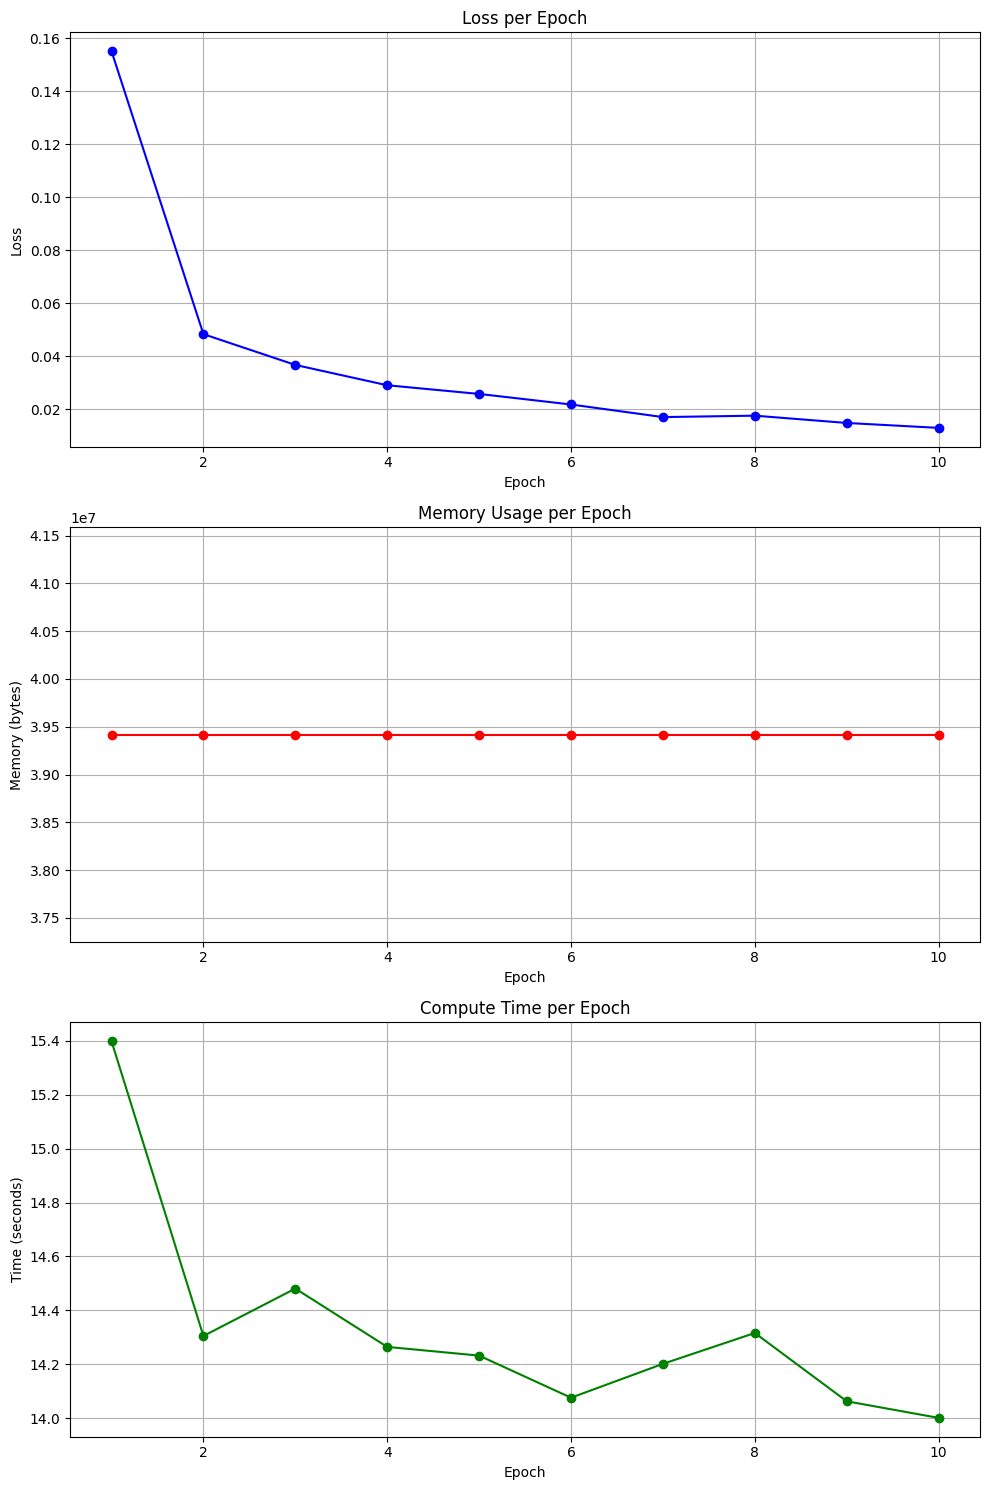

In [ ]:
le1 = le1.to('cuda')
optimizer1 = optim.Adam(le1.parameters(), lr=0.001)
train_model(le1, trainloader, epochs=10, optimizer=optimizer1, loss_function=criterion)

Epoch 1, Loss: 0.15556566352828907, Memory Usage: 41429504 bytes, Compute Time: 14.833724975585938 seconds
Epoch 2, Loss: 0.05478515098792817, Memory Usage: 40423936 bytes, Compute Time: 14.675477266311646 seconds
Epoch 3, Loss: 0.036699520635988504, Memory Usage: 40423936 bytes, Compute Time: 14.821646451950073 seconds
Epoch 4, Loss: 0.029533281988615216, Memory Usage: 40423936 bytes, Compute Time: 14.947009563446045 seconds
Epoch 5, Loss: 0.02386929873014807, Memory Usage: 40423936 bytes, Compute Time: 14.822997570037842 seconds
Epoch 6, Loss: 0.02096067006027188, Memory Usage: 40423936 bytes, Compute Time: 14.741058826446533 seconds
Epoch 7, Loss: 0.01646765800181348, Memory Usage: 40423936 bytes, Compute Time: 14.614843368530273 seconds
Epoch 8, Loss: 0.014736090440658415, Memory Usage: 40423936 bytes, Compute Time: 14.840781688690186 seconds
Epoch 9, Loss: 0.014192875820834602, Memory Usage: 40423936 bytes, Compute Time: 15.014671802520752 seconds
Epoch 10, Loss: 0.010948968986285

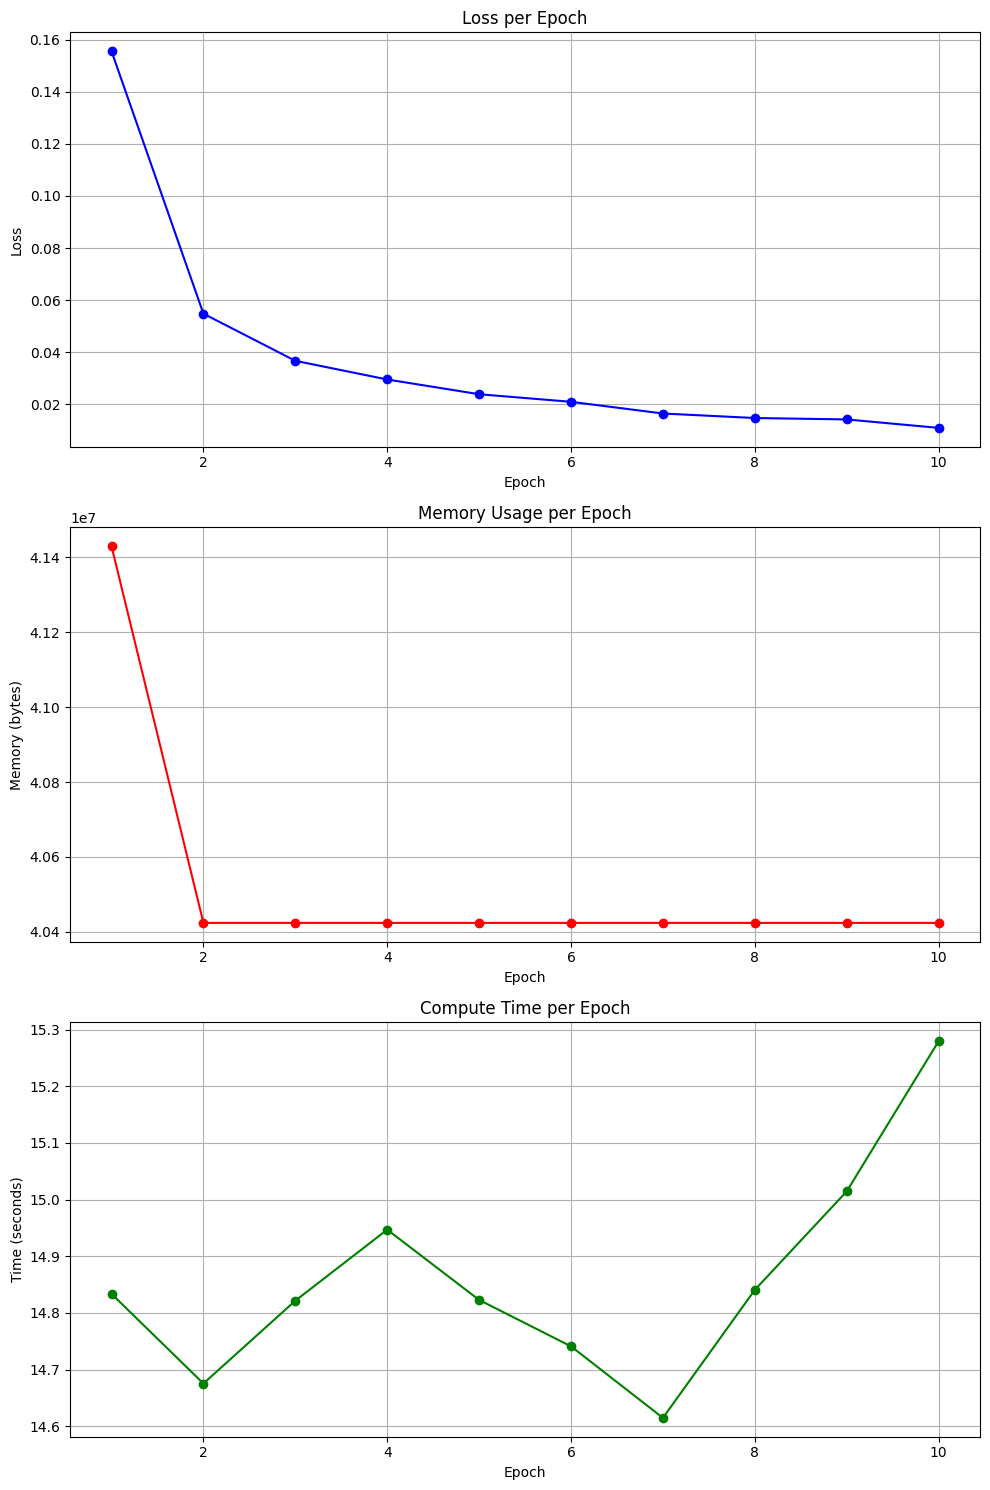

In [ ]:
le2 = le2.to('cuda')
optimizer2 = optim.Adam(le2.parameters(), lr=0.001)
train_model(le2, trainloader, epochs=10, optimizer=optimizer2, loss_function=criterion)

#ResNet Definition

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = BatchNorm1dNewO(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm1dNewO(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm1dNewO(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = BatchNorm1dNewO(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool1d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Example: ResNet18
def ResNet18():
    return ResNet1D(BasicBlock, [2, 2, 2, 2])

model1 = ResNet18()
print(model1)


ResNet1D(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1dNewO()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1dNewO()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1dNewO()
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1dNewO()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1dNewO()
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1dNewO()
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2):

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlockUpdated(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockUpdated, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = BatchNorm1dNew(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm1dNew(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm1dNew(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet1DUpdated(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet1DUpdated, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = BatchNorm1dNew(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool1d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Example: ResNet18
def ResNet18U():
    return ResNet1DUpdated(BasicBlockUpdated, [2, 2, 2, 2])

model2 = ResNet18U()
print(model2)


ResNet1DUpdated(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1dNew()
  (layer1): Sequential(
    (0): BasicBlockUpdated(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1dNew()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1dNew()
      (shortcut): Sequential()
    )
    (1): BasicBlockUpdated(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1dNew()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1dNew()
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlockUpdated(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1dNew()
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bi

#SPEECHCOMMANDS Data Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from torchaudio.datasets import SPEECHCOMMANDS
import os

data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
# Define a preprocessing function
def preprocess_waveform(waveform, sample_rate, pad_length=16000):
    # Resample to 8kHz
    resampler = T.Resample(orig_freq=sample_rate, new_freq=8000)
    waveform = resampler(waveform)
    # Pad or trim to fixed length
    if waveform.size(1) > pad_length:
        waveform = waveform[:, :pad_length]
    elif waveform.size(1) < pad_length:
        padding = pad_length - waveform.size(1)
        waveform = nn.functional.pad(waveform, (0, padding))
    return waveform

# Custom dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, subset, root, transform=None):
        # Now the root directory is configurable
        self.dataset = SPEECHCOMMANDS(root=root, download=True, subset=subset)
        self.transform = transform
        self.labels = sorted(list(set(datapoint[2] for datapoint in self.dataset)))
        self.label_to_index = {label: index for index, label in enumerate(self.labels)}

    def __getitem__(self, index):
        waveform, sample_rate, label, _, _ = self.dataset[index]
        if self.transform:
            waveform = self.transform(waveform, sample_rate)
        label_index = self.label_to_index[label]
        return waveform, label_index

    def __len__(self):
        return len(self.dataset)


# Instantiate datasets
train_dataset = SpeechCommandsDataset(subset='training', transform=preprocess_waveform, root=data_dir)
val_dataset = SpeechCommandsDataset(subset='validation', transform=preprocess_waveform, root=data_dir)


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)



100%|██████████| 2.26G/2.26G [00:11<00:00, 212MB/s]


#ResNet Training over SPEECHCOMMANDS

In [ ]:
model1 = ResNet1D(BasicBlock, [2, 2, 2, 2], num_classes=len(train_dataset.labels))
loss_function = nn.CrossEntropyLoss()
model1 = model1.to('cuda')
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_model(model1, train_loader, epochs=1, optimizer=optimizer, loss_function=loss_function)

Epoch 1, Loss: 2.1196755894978123, Memory Usage: 4126124032 bytes, Compute Time: 1688.9167294502258 seconds


In [ ]:
model2 = ResNet1DUpdated(BasicBlockUpdated, [2, 2, 2, 2], num_classes=len(train_dataset.labels))
loss_function = nn.CrossEntropyLoss()
model2 = model2.to('cuda')
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
train_model(model2, train_loader, epochs=1, optimizer=optimizer2, loss_function=loss_function)

OutOfMemoryError: CUDA out of memory. Tried to allocate 250.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 123.06 MiB is free. Process 10855 has 14.62 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 244.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)